In [1]:
import random
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from gensim import models
from gensim.corpora.dictionary import Dictionary
from Bio.Cluster import kcluster
from sklearn import svm
from sklearn.model_selection import train_test_split

# 功能区数量
ZONE_NUM = 592

#topic数量
_topicNum = 200
#固定聚类初始化参数
random.seed(62)
ZONE_CLUSTER_SEED = [random.randint(0 ,12) for i in range(ZONE_NUM)]
TOPIC_CLUSTER_SEED = [random.randint(0 ,12) for i in range(_topicNum)]

#poi数据路径
poi_file_path = r'data/BJCY_5/bjcy592_pois.txt'
#数据维度
vec_dim = 200
len_zones = ZONE_NUM

dis_threshold = 0.018
# word_vec_path = r'.\data\wordvec_place2vec.txt'
zone_vec_path = r'.\data\SLDA1\lda\zone_vec.txt'

zone_cluster_num = 13
topic_cluster_num = 13
#topic-vec存放路径
topic_vec_path = r'.\data\SLDA1\lda\topic_vec.txt'
#zone-vec存放路径
path_to_zoneVec = r'.\data\SLDA1\lda\zone_topic.txt'
# svm标签
path_to_label = r'data/BJCY_5/bjcy592_label9.txt'
#zonevec带有label11标签的路径
zonevec_withlabel_output_path =r'.\data\SLDA1\lda\zoneVecWithCl.txt'

#svm分割尺寸
TRAIN_SIZE = 0.6
TEST_SIZE = 1 - TRAIN_SIZE

#####  1、加载词向量数据，将词汇和对应的词向量存储在名为 word_dic 的字典中，其中键是词，值是词向量。

In [2]:
# def load_word_vec(path):
#     word_dic = {}
#     with open(path, 'r',encoding='utf-8') as f2:
#         f2.readline() #去头
#         for line in f2.readlines():
#             line = line.split(' ')
#             word = line[0]
#             del line[0]
#             word_dic[word] = []
#             for item in line:
#                 word_dic[word].append(eval(item))
#     return word_dic
# 
# word_dic = load_word_vec(word_vec_path)
# word_dic

##### 2、加载POI数据，将其按照区域（zone）ID划分，将结果存储在 zones 中。

In [3]:
def load_all_pois_2_zones(path):
    a = []
    with open(path,"r",encoding = "utf-8") as f:
        f.readline() #去头
        for line in f.readlines():
            line = line.replace('\n', '').split(',')
            a.append(line)
    zones = [[] for i in range(len_zones)]
    for i in a:
        zones[eval(i[4])].append([eval(i[2])] + [eval(i[3])] + [i[1]])
    return zones


zones = load_all_pois_2_zones(poi_file_path)
zones

[[[116.48454196, 39.8150256511, '道路名'],
  [116.48116996, 39.8181505364, '路口名'],
  [116.482953685, 39.8176137934, '汽车租赁'],
  [116.484379115, 39.8169110351, '汽车维修'],
  [116.483964616, 39.8164528475, '洗车场'],
  [116.483887302, 39.8166456061, '汽车销售'],
  [116.488586946, 39.8171804729, '村庄级地名'],
  [116.487010837, 39.8184227058, '公证鉴定机构'],
  [116.487765842, 39.8171820339, '公司'],
  [116.487768852, 39.8171890423, '公司'],
  [116.489054727, 39.8170868704, '便民商店/便利店'],
  [116.490102681, 39.817188982, '公共厕所'],
  [116.491428835, 39.8161350096, '路口名'],
  [116.493669223, 39.8169596339, '公交车站相关'],
  [116.493191328, 39.8176391592, '摄影冲印'],
  [116.493171293, 39.8173061232, '政府机关相关'],
  [116.493353003, 39.8171376775, '政府机关相关'],
  [116.493824752, 39.817449063, '加油站'],
  [116.481954738, 39.8193427441, '生活服务场所'],
  [116.481330326, 39.8200218718, '公司'],
  [116.486807999, 39.8190140627, '公共厕所'],
  [116.489679741, 39.819932528, '公共厕所'],
  [116.494457874, 39.8196877934, '建材五金市场'],
  [116.49428737, 39.8185363661, '

##### 3、将区域（zone）中的POI进一步划分为子文档（sub_doc），并且根据一定的阈值 (dis_threshold) 对POI进行分散度计算。
#####   返回划分后的子文档及分散的POI信息。

In [4]:
# POI点聚类函数
def ac(X, _distance_threshold):
    # 将输入的点坐标数据转换为NumPy数组
    X = np.array(X)

     # 使用凝聚层次聚类算法（Agglomerative Clustering）对点进行聚类
    ac = AgglomerativeClustering(affinity='euclidean', linkage='ward', distance_threshold = _distance_threshold, n_clusters = None)
    labels = ac.fit_predict(X)  # 用于拟合数据并返回每个数据点的聚类标签。
    # n_clusters： 整数，表示要形成的最终聚类的数量。也可以通过distance_threshold参数来指定阈值，当距离超过该阈值时停止合并。
    # 
    # affinity： 表示用于计算链接的距离度量。可以选择的值有：
    # 
    # "euclidean"：欧氏距离。
    # "l1"：曼哈顿距离。
    # "l2"：曼哈顿距离的平方。
    # "manhattan"：曼哈顿距离。
    # "cosine"：余弦相似度。
    # linkage： 表示用于计算链接的方法。可以选择的值有：
    # 
    # "ward"：使用 Ward 方差最小化算法。
    # "complete"：使用最大链接算法。
    # "average"：使用平均链接算法。
    # "single"：使用最小链接算法。
    # distance_threshold： 一个可选的浮点数，表示停止合并聚类的距离阈值。如果设置了这个值，那么 n_clusters 将被忽略。
    # 
    # compute_full_tree： 一个布尔值，表示是否计算完整的连接矩阵。如果设置为 True，将计算所有数据点之间的距离，并构建完整的连接矩阵；如果设置为 False，将使用一种更有效的策略来计算。
    # 
    # n_neighbors： 当 affinity 设置为 "nearest_neighbors" 时使用，表示在计算链接时考虑每个数据点的近邻数量。

    #统计聚簇数量
    count = []  # 用于存储聚类标签
    cluster_count = 0  # 用于计算聚类数量的变量

    # 遍历所有点的标签
    for i in labels:
        if i in count:
            continue  # 如果标签已经出现过，继续下一个
        else:
            count.append(i)  # 将新的标签添加到列表
            cluster_count += 1  # 聚类数量加1

    # 返回聚类的数量和每个点的聚类标签
    return cluster_count, labels

def get_all_sub_doc(zones, dis):
    # 初始化空列表用于存储每个区域的标签和离散点
    labels = [[] for i in range(len_zones)]
    all_doc = [] # 存储所有文档的列表，0维度表示区域编号，1维度表示文档编号，2维度表示文档内容
    dispersedPOI = []  # 存每个区域离散点

    #对每个区域ac，并将大于阈值的聚簇添加到doc
    for i in range(0, len(zones)): #对每个区域
        dispersedPOI.append([]) #初始化本区域离散点数组

        # 如果当前区域内的点数量太少（少于10个），将其视为离散点并跳过聚类过程
        if len(zones[i]) < 5:
            all_doc.append([]) # 使用空列表表示该区域没有文档
            for k in range(0, len(zones[i])):
                dispersedPOI[i].append(k) #将点添加到离散点数组
            continue #处理下个区域

        all_doc.append([]) # 初始化当前区域的文档列表
        temp_zone = []     # 临时存储当前区域的点坐标
        for item in zones[i]:
            temp_zone.append([item[0],item[1]])

        X = temp_zone   # 区域点坐标的列表

        cluster_num, labels[i] = ac(X, dis) # 使用AC算法聚类当前区域的点，并获取聚类数量和所有点的标签
        #print("cluster_num：",cluster_num)
        label = []  # 用于统计每个聚类中的点数

        # 初始化每个聚类的点数计数
        for j in range(0,cluster_num):
            label.append(0)

        # 统计每个标签对应的点数
        for j in labels[i]:
            label[j] += 1

        # 获取文档中的点的序号
        for j in range(0, cluster_num):  # j是聚簇编号
            _doc = []
            for k in range(0,len(labels[i])):
                if labels[i][k] == j:
                    _doc.append(k)
            all_doc[i].append(_doc)

        # 如果当前区域没有文档，添加一个空文档列表
        if all_doc[i] == []:
            all_doc[i].append([])
        #print(i,"th ac over")

    # 所有子区域划分完毕
    print("所有子区域划分完毕")
    return all_doc, dispersedPOI
#all_doc[i][j] 表示第 i 个区域内的第 j 个文档，而 all_doc[i][j] 的值是一个列表，包含了该文档内的POI点的序号。
#dispersedPOI[i] 表示第 i 个区域内的离散点的序号列表。

#all_doc 存储了具有足够多点数的文档片段，而 dispersedPOI 存储了未能满足文档要求的离散点，这有助于后续的文本数据处理和分析。

zone_with_sub_doc_poi, dispersedPOI = get_all_sub_doc(zones, dis_threshold)
print(zone_with_sub_doc_poi)
dispersedPOI

E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.p

所有子区域划分完毕
[[[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34], [0, 1, 2, 3, 4, 5, 18, 19, 28, 29], [47, 48, 50, 51, 58, 59, 67, 68, 69, 70, 71], [72], [60, 61, 62, 63, 64, 65, 66], [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 52, 53, 54, 55, 56, 57]], [[22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 191, 192, 193, 196, 197, 199, 201, 202, 204, 205, 206, 207, 208, 209, 211, 212, 213, 215, 216, 217, 218, 219, 220, 223, 224, 225, 226, 228, 230, 233, 234, 237, 238, 240, 242, 243, 244, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 282, 636, 637, 638, 641, 642, 643, 644, 645, 646, 649, 650], [235, 236, 239, 241, 248, 281, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300, 301, 302, 303, 304, 315, 321, 648, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 6

E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
E:\User\pycharm_project\SLDA_SVM\venv\lib\site-packages\sklearn\cluster\_agglomerative.p

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


#####  4、使用LDA算法计算每个子文档的主题分布，主题-词分布以及子文档-POI分布。

In [5]:
def computeLDA(all_doc, zones):

    topic_word = [] # 存储主题下单词的分布
    doc_topic = [] # 存储文档下主题的分布
    doc_topic_name = []
    _doc = []

    # 先把doc拉直
    # 将文档内容展开为一维数组
    for i in range(0, len(all_doc)): # 遍历每个区域
        # 对两个分布初始化
        # 没有顺序，直接用list记录
        for j in range(0, len(all_doc[i])):  # 遍历每个文档
            doc_topic.append([]) # 初始化文档下主题分布的列表
            doc_topic_name.append([])
            temp_doc = []   # 用于存储当前文档的POI点
            if all_doc[i][j] != []:  # 检查当前文档是否包含POI点,如果不为空:
                for item in all_doc[i][j]:  # 遍历当前文档中的每个POI点
                    # 从 zones 中提取第 i 区域的第 item 个POI点的第三个元素（通常是POI点的信息或文本）并将其添加到 temp_doc 列表中。
                    temp_doc.append(zones[i][item][2])
            _doc.append(temp_doc) # 将 temp_doc 列表添加到 _doc 列表中，将文档的POI点信息保存在 _doc 中。

#_doc:[['路口名', '路口名', '紧急避难场所', '路口名', '休闲场所', '路口名', '公司', '公共停车场', '专营店', '汽车服务相关', '汽车服务相关', '工厂', '工厂', '公园', '公共停车场', '诊所', '停车场相关', '诊所', '公共厕所', '餐饮相关', '专营店', '专营店', '美容美发店', '公共停车场', '公共厕所', '公园', '公司', '公园', '紧急避难场所', '路口名', '道路名', '美术馆', '商务写字楼', '厨卫市场', '公司', '科研机构', '汽车服务相关', '建材五金市场', '公共厕所'],........

    # 运行LDA模型
    dictionary = Dictionary(_doc)  # 创建字典
    corpus = [dictionary.doc2bow(text) for text in _doc]  # 将文档转换为词袋表示
    lda = models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, iterations=1000, num_topics = _topicNum, random_state = 1)

    #得到两个分布
    topic_list = lda.print_topics(num_topics=_topicNum, num_words=20) # 主题下词的分布
    all_topics = lda.get_document_topics(corpus, per_word_topics=True, minimum_probability=0)



    i = 0
    # 1、文档下主题的分布概率
    for docInfo in all_topics:
        docTopics = docInfo[0]
        for topic in docTopics:
            doc_topic_name[i].append(topic[0])
            doc_topic[i].append(topic[1])  # 将每个主题的概率添加到文档下主题分布
        i += 1
    print("doc_topic geted")

    ## 写入文件
    with open(r'.\data\SLDA1\lda\doc_topic_name.txt', 'w', encoding = 'utf-8') as f:
        for line in doc_topic_name:
            line = [str(i) for i in line]
            f.write(' '.join(line))
            f.write('\n')
        f.close()

    ####################
    # 对文档的主题分布进行相加到zone_topic中去
    index = 0  # 文档编号
    # zone_topic = []
    # zone_topic_name = [[0 for _ in range(_topicNum)] for _ in range(ZONE_NUM)]
    zone_topic_prob = [[0 for _ in range(_topicNum)] for _ in range(ZONE_NUM)]

    # 现在将区域内的文档主题分布相加
    for j in range(ZONE_NUM):

        count_doc = len(zone_with_sub_doc_poi[j])
        temp_doc_topic = []
        if count_doc !=0:
            for k in range(count_doc):
                temp_doc_topic.append(doc_topic[index])
                index+=1
            # 对temp_doc_topic的每个列表中的元素进行相加，并将结果存储到zone_topic中
            for t in range(_topicNum):
                for item in temp_doc_topic:
                    zone_topic_prob[j][t] += item[t]
        else:
            print(str(j)+"区域有0个文档")
            
            

    print(zone_topic_prob)  # 输出相加后的结果

    # 对相加后的结果归一化处理
    normalized_zone_topic = []
    # 计算每一行的总和
    row_sums = [sum(row) for row in zone_topic_prob]
    # 归一化每一行并存储到新列表中
    for j in range(ZONE_NUM):
        if row_sums[j] != 0:
            normalized_row = [value / row_sums[j] for value in zone_topic_prob[j]]
            normalized_zone_topic.append(normalized_row)
        else:
            # 若总和为 0，则添加与原始行相同的值
            normalized_zone_topic.append(zone_topic_prob[j])

    print(normalized_zone_topic)  # 输出归一化后的结果

    ## 写入文件
    with open(r'.\data\SLDA1\lda\zone_topic.txt', 'w', encoding = 'utf-8') as f:
        for line in normalized_zone_topic:
            line = [str(i) for i in line]
            f.write(' '.join(line))
            f.write('\n')
        f.close()

    # 2、主题下单词概率分布
    for i in range(0,len(topic_list)): #i遍历主题数
        topic_word.append({})  # 为每个主题创建一个字典，用于存储单词概率
        item = topic_list[i][1].split('+')  # 从 topic_list 中获取第 i 个主题的单词分布字符串，然后使用加号分割字符串，以获取单词和其概率的对应关系。
        for item2 in item:
            item2 = item2.split('*')  # 分离单词和其概率值。
            topic_word[i][eval(item2[1])] = eval(item2[0])  # 将单词（由 item2[1] 给出）和概率值（由 item2[0] 给出）添加到 topic_word 中的第 i 个主题的字典中。这样，topic_word 包含了每个主题下的单词分布概率。
    print("topic_word geted")

    with open(r'.\data\SLDA1\lda\doc_topic.txt', 'w', encoding = 'utf-8') as f:
        for line in doc_topic:
            line = [str(i) for i in line]
            f.write(' '.join(line))
            f.write('\n')
        f.close()
    with open(r'.\data\SLDA1\lda\topic_word.txt', 'w', encoding = 'utf-8') as f:
        for line in topic_word:
            line = [str(i) for i in line]
            f.write(' '.join(line))
            f.write('\n')
        f.close()
    return doc_topic, topic_word, _doc


doc_topic_prob, topic_word, sub_doc_poi = computeLDA(zone_with_sub_doc_poi, zones)
print(doc_topic_prob)
print(topic_word)
print(sub_doc_poi)

doc_topic geted
217区域有0个文档
298区域有0个文档
366区域有0个文档
432区域有0个文档
446区域有0个文档


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



##### K-means:

In [6]:
# from sklearn.metrics import silhouette_score
#
# x = []
# y = []
# for n_clusters in range(7, 15):
#     #轮廓系数
#     cluster_labels, error, nfound = kcluster(zone_vec, n_clusters, dist='e', npass=100, method='a')
#     silhouette_avg = silhouette_score(zone_vec, cluster_labels, metric='cosine')
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)
#     x.append(n_clusters)
#     y.append(silhouette_avg)

In [7]:
# from matplotlib import pyplot as plt
#
# plt.scatter(x,y,color='green')
# plt.xticks(x)
# plt.show()

For n_clusters = 7 The average silhouette_score is : 0.12019939773069817
For n_clusters = 8 The average silhouette_score is : 0.11832170518999989
For n_clusters = 9 The average silhouette_score is : 0.08024612895224564
For n_clusters = 10 The average silhouette_score is : 0.0863332554990783
For n_clusters = 11 The average silhouette_score is : 0.0732373897764005
For n_clusters = 12 The average silhouette_score is : 0.09531507352398243
For n_clusters = 13 The average silhouette_score is : 0.14884528808303135
For n_clusters = 14 The average silhouette_score is : 0.0996120840374421

##### 平均相似度计算

##### SVM


In [8]:

def process_zoneVec_file(zoneVec_path, label_path, output_path):
    # 读取标签文件
    with open(label_path, 'r') as label_file:
        labels = label_file.readlines()
        labels = [label.strip() for label in labels]

    # 读取并处理 zoneVec 文件
    with open(zoneVec_path, 'r') as zoneVec_file:
        lines = zoneVec_file.readlines()
        lines = [line.strip().split() for line in lines]

    # 并且将空格替换为逗号
    zoneVec_data = [','.join(line[0:]) for line in lines[0:]]

    # 合并标签并写入输出文件
    with open(output_path, 'w', encoding='utf-8') as output_file:
        for i, zoneVec_row in enumerate(zoneVec_data):
            label = labels[i] if i < len(labels) else ''
            output_file.write(zoneVec_row + ',' + label + '\n')

# 执行处理
process_zoneVec_file(path_to_zoneVec, path_to_label, zonevec_withlabel_output_path)

In [9]:
import pandas as pd

PATH_TO_SVMVEC = r'.\data\SLDA1\lda'

PATH_TO_SVMRES = r'.\data\SLDA1\SVM'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# define converts(字典)
def create_iris_label_dict():
    it = {}
    for i in range(50):
        it[bytes(str(i), 'utf-8')] = i
    return it

def Iris_label(s):
    iris_dict = create_iris_label_dict()
    return iris_dict[s]

In [10]:
from IPython.core.display import HTML
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import svm
import pandas as pd
import numpy as np

# 1. 读取数据集
path = zonevec_withlabel_output_path
data = np.loadtxt(path, dtype=float, delimiter=',', converters={vec_dim: Iris_label})

# 2. 划分数据与标签
x, y = np.split(data, indices_or_sections=(vec_dim,), axis=1)  # x为数据，y为标签
x = x[:, 0:vec_dim]
train_data, test_data, train_label, test_label, train_indices, test_indices = train_test_split(
    x, y, range(len(y)), random_state=1, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

# 3. 训练svm分类器
classifier = svm.SVC(C=100, kernel='rbf', gamma=3, decision_function_shape='ovo')  # ovr:一对多策略
classifier.fit(train_data, train_label.ravel())

# 4. 计算svc分类器的准确率
print("训练集个数：" + str(len(train_data)))
a = classifier.score(train_data, train_label)
b = classifier.score(test_data, test_label)
OA = a * TRAIN_SIZE + b * TEST_SIZE
print("训练集：", a)
print("测试集：", b)
print("!!!总体精度: ", OA)


# 5. 相关指标计算
# (1). 计算混淆矩阵和相关指标（训练集）
train_predictions = classifier.predict(train_data)

# 获取类别数量
num_classes = len(np.unique(train_label))

# 混淆矩阵
confusion_matrix_train = confusion_matrix(train_label, train_predictions)

# 计算百分比混淆矩阵
confusion_matrix_train_percentage = confusion_matrix_train / confusion_matrix_train.sum(axis=1, keepdims=True)

# 计算相关指标
accuracy_train = accuracy_score(train_label, train_predictions)
precision_train = precision_score(train_label, train_predictions, average='weighted')
recall_train = recall_score(train_label, train_predictions, average='weighted')
f1_train = f1_score(train_label, train_predictions, average='weighted')

# 输出训练集结果
print("训练集混淆矩阵:")
confusion_matrix_train_df = pd.DataFrame(
    confusion_matrix_train_percentage, columns=["Predicted " + str(i) for i in range(num_classes)],
    index=["Actual " + str(i) for i in range(num_classes)]
)
display(confusion_matrix_train_df)
print("训练集准确率: {:.2%}".format(accuracy_train))
print("训练集精确率: {:.2%}".format(precision_train))
print("训练集召回率: {:.2%}".format(recall_train))
print("训练集F1分数: {:.2%}".format(f1_train))

# (2). 计算混淆矩阵和相关指标（测试集）
test_predictions = classifier.predict(test_data)

# 混淆矩阵
confusion_matrix_test = confusion_matrix(test_label, test_predictions)

# 计算百分比混淆矩阵
confusion_matrix_test_percentage = confusion_matrix_test / confusion_matrix_test.sum(axis=1, keepdims=True)

# 计算相关指标
accuracy_test = accuracy_score(test_label, test_predictions)
precision_test = precision_score(test_label, test_predictions, average='weighted')
recall_test = recall_score(test_label, test_predictions, average='weighted')
f1_test = f1_score(test_label, test_predictions, average='weighted')

# 输出测试集结果
print("\n测试集混淆矩阵:")
confusion_matrix_test_df = pd.DataFrame(
    confusion_matrix_test_percentage, columns=["Predicted " + str(i) for i in range(num_classes)],
    index=["Actual " + str(i) for i in range(num_classes)]
)
display(confusion_matrix_test_df)
print("测试集准确率: {:.2%}".format(accuracy_test))
print("测试集精确率: {:.2%}".format(precision_test))
print("测试集召回率: {:.2%}".format(recall_test))
print("测试集F1分数: {:.2%}".format(f1_test))

# (3). 合并训练集和测试集的数据和标签
all_data = np.vstack((train_data, test_data))
all_label = np.vstack((train_label, test_label))

# 按照原始顺序进行预测
all_predictions = classifier.predict(all_data)

# 混淆矩阵
confusion_matrix_all = confusion_matrix(all_label, all_predictions)

# 计算百分比混淆矩阵
confusion_matrix_all_percentage = confusion_matrix_all / confusion_matrix_all.sum(axis=1, keepdims=True)

# 计算相关指标
accuracy_all = accuracy_score(all_label, all_predictions)
precision_all = precision_score(all_label, all_predictions, average='weighted')
recall_all = recall_score(all_label, all_predictions, average='weighted')
f1_all = f1_score(all_label, all_predictions, average='weighted')

# 输出整体结果
print("\n总体混淆矩阵（数目）:")
confusion_matrix_all_df = pd.DataFrame(
    confusion_matrix_all, columns=["Predicted " + str(i) for i in range(num_classes)],
    index=["Actual " + str(i) for i in range(num_classes)]
)
display(confusion_matrix_all_df)
print("总体准确率: {:.2f}".format(accuracy_all))
print("总体精确率: {:.2f}".format(precision_all))
print("总体召回率: {:.2f}".format(recall_all))
print("总体F1分数: {:.2f}".format(f1_all))

# 输出整体结果
print("\n总体混淆矩阵:")
confusion_matrix_all_df = pd.DataFrame(
    confusion_matrix_all_percentage, columns=["Predicted " + str(i) for i in range(num_classes)],
    index=["Actual " + str(i) for i in range(num_classes)]
)
display(confusion_matrix_all_df)
print("总体准确率: {:.2%}".format(accuracy_all))
print("总体精确率: {:.2%}".format(precision_all))
print("总体召回率: {:.2%}".format(recall_all))
print("总体F1分数: {:.2%}".format(f1_all))


# (4). 保存排序后的标签
index_and_predictions = pd.DataFrame({
    'Index': np.hstack((train_indices, test_indices)),
    'Original_Label': all_label.flatten(),
    'SVM_Predicted_Label': all_predictions.flatten()
})

# 保存到指定路径
save_path = 'data/SLDA1/SVM/index_and_predictions.csv'
index_and_predictions.to_csv(save_path, index=False)
print(f"排序后的标签已保存到：{save_path}")


训练集个数：355
训练集： 0.9943661971830986
测试集： 0.5611814345991561
!!!总体精度:  0.8210922921495216
训练集混淆矩阵:


Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0          1.0     0.000000          0.0     0.000000          0.0   
Actual 1          0.0     0.992308          0.0     0.000000          0.0   
Actual 2          0.0     0.000000          1.0     0.000000          0.0   
Actual 3          0.0     0.000000          0.0     0.923077          0.0   
Actual 4          0.0     0.000000          0.0     0.000000          1.0   
Actual 5          0.0     0.000000          0.0     0.000000          0.0   
Actual 6          0.0     0.000000          0.0     0.000000          0.0   
Actual 7          0.0     0.000000          0.0     0.000000          0.0   
Actual 8          0.0     0.000000          0.0     0.000000          0.0   

          Predicted 5  Predicted 6  Predicted 7  Predicted 8  
Actual 0          0.0     0.000000          0.0          0.0  
Actual 1          0.0     0.007692          0.0          0.0  
Actual 2          0.0     0.000000          0.0          0.0  
Actual 3          0.0     0.076923          0.0          0.0  
Actual 4          0.0     0.000000          0.0          0.0  
Actual 5          1.0     0.000000          0.0          0.0  
Actual 6          0.0     1.000000          0.0          0.0  
Actual 7          0.0     0.000000          1.0          0.0  
Actual 8          0.0     0.000000          0.0          1.0

训练集准确率: 99.44%
训练集精确率: 99.45%
训练集召回率: 99.44%
训练集F1分数: 99.43%

测试集混淆矩阵:


Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0     0.125000     0.062500     0.312500     0.312500     0.062500   
Actual 1     0.000000     0.810811     0.054054     0.000000     0.054054   
Actual 2     0.030303     0.393939     0.303030     0.030303     0.060606   
Actual 3     0.600000     0.100000     0.100000     0.100000     0.000000   
Actual 4     0.076923     0.307692     0.307692     0.000000     0.153846   
Actual 5     0.111111     0.111111     0.111111     0.000000     0.000000   
Actual 6     0.000000     0.108108     0.270270     0.027027     0.027027   
Actual 7     0.000000     0.000000     0.000000     0.000000     0.200000   
Actual 8     0.000000     0.000000     0.000000     0.000000     0.000000   

          Predicted 5  Predicted 6  Predicted 7  Predicted 8  
Actual 0     0.000000     0.125000     0.000000     0.000000  
Actual 1     0.018018     0.063063     0.000000     0.000000  
Actual 2     0.030303     0.121212     0.000000     0.030303  
Actual 3     0.000000     0.100000     0.000000     0.000000  
Actual 4     0.000000     0.000000     0.153846     0.000000  
Actual 5     0.555556     0.111111     0.000000     0.000000  
Actual 6     0.000000     0.540541     0.000000     0.027027  
Actual 7     0.000000     0.200000     0.600000     0.000000  
Actual 8     0.000000     1.000000     0.000000     0.000000

测试集准确率: 56.12%
测试集精确率: 54.98%
测试集召回率: 56.12%
测试集F1分数: 55.48%

总体混淆矩阵（数目）:


Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0           24            1            5            5            1   
Actual 1            0          219            6            0            6   
Actual 2            1           13           80            1            2   
Actual 3            6            1            1           13            0   
Actual 4            1            4            4            0           17   
Actual 5            1            1            1            0            0   
Actual 6            0            4           10            1            1   
Actual 7            0            0            0            0            1   
Actual 8            0            0            0            0            0   

          Predicted 5  Predicted 6  Predicted 7  Predicted 8  
Actual 0            0            2            0            0  
Actual 1            2            8            0            0  
Actual 2            1            4            0            1  
Actual 3            0            2            0            0  
Actual 4            0            0            2            0  
Actual 5           18            1            0            0  
Actual 6            0           86            0            1  
Actual 7            0            1           16            0  
Actual 8            0            3            0           13

总体准确率: 0.82
总体精确率: 0.82
总体召回率: 0.82
总体F1分数: 0.82

总体混淆矩阵:


Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0     0.631579     0.026316     0.131579     0.131579     0.026316   
Actual 1     0.000000     0.908714     0.024896     0.000000     0.024896   
Actual 2     0.009709     0.126214     0.776699     0.009709     0.019417   
Actual 3     0.260870     0.043478     0.043478     0.565217     0.000000   
Actual 4     0.035714     0.142857     0.142857     0.000000     0.607143   
Actual 5     0.045455     0.045455     0.045455     0.000000     0.000000   
Actual 6     0.000000     0.038835     0.097087     0.009709     0.009709   
Actual 7     0.000000     0.000000     0.000000     0.000000     0.055556   
Actual 8     0.000000     0.000000     0.000000     0.000000     0.000000   

          Predicted 5  Predicted 6  Predicted 7  Predicted 8  
Actual 0     0.000000     0.052632     0.000000     0.000000  
Actual 1     0.008299     0.033195     0.000000     0.000000  
Actual 2     0.009709     0.038835     0.000000     0.009709  
Actual 3     0.000000     0.086957     0.000000     0.000000  
Actual 4     0.000000     0.000000     0.071429     0.000000  
Actual 5     0.818182     0.045455     0.000000     0.000000  
Actual 6     0.000000     0.834951     0.000000     0.009709  
Actual 7     0.000000     0.055556     0.888889     0.000000  
Actual 8     0.000000     0.187500     0.000000     0.812500

总体准确率: 82.09%
总体精确率: 81.98%
总体召回率: 82.09%
总体F1分数: 81.99%
排序后的标签已保存到：data/SLDA1/SVM/index_and_predictions.csv


In [11]:
# import os
# path_to_svm = r'data/SLDA1/SVM'
# train_path = path_to_svm + '/zonecls_train.txt'
# # print(os.path.exists(train_path))
# tra_flabel = open(train_path, "w", encoding = "utf-8") # 预测标签
# tra_rule = classifier.predict(train_data)
# for x in tra_rule:
#     m=int(x)
#     tra_flabel.write(str(m))
#     tra_flabel.write('\n')
# tra_flabel.close()
# print(f"File '{train_path}' has been written successfully.")
# 
# test_path = path_to_svm + '/zonecls_test.txt'
# tes_flabel = open(test_path,"w",encoding = "utf-8") # 预测标签
# tes_rule=classifier.predict(test_data)
# for j in tes_rule:
#     n=int(j)
#     tes_flabel.write(str(n))
#     tes_flabel.write('\n')
# tes_flabel.close()
# print(f"File '{test_path}' has been written successfully.")

######  其他的一些评价指标

In [12]:
from sklearn.metrics import cohen_kappa_score

# 4. 合并数据集
merged_data = np.vstack((train_data, test_data))
merged_label = np.vstack((train_label, test_label))

# 5. 计算svc分类器的准确率
print("总体样本个数：" + str(len(merged_data)))
overall_accuracy = accuracy_score(merged_label, classifier.predict(merged_data))
print("总体精度: ", overall_accuracy)

# 6. 计算其他评价指标
precision_overall = precision_score(merged_label, classifier.predict(merged_data), average='weighted')
recall_overall = recall_score(merged_label, classifier.predict(merged_data), average='weighted')
f1_overall = f1_score(merged_label, classifier.predict(merged_data), average='weighted')

# 7. 输出其他评价指标
print("精确度 (总体):", precision_overall)
print("召回率 (总体):", recall_overall)
print("F1分数 (总体):", f1_overall)
# 9. 计算Kappa系数
kappa_score = cohen_kappa_score(merged_label, classifier.predict(merged_data))
print("Kappa系数:", kappa_score)
# 8. 输出混淆矩阵
cm_overall = confusion_matrix(merged_label, classifier.predict(merged_data))

print("混淆矩阵 (总体):\n", cm_overall)

总体样本个数：592
总体精度:  0.8209459459459459
精确度 (总体): 0.8197670549792825
召回率 (总体): 0.8209459459459459
F1分数 (总体): 0.8198787392559769
Kappa系数: 0.7643869562768694
混淆矩阵 (总体):
 [[ 24   1   5   5   1   0   2   0   0]
 [  0 219   6   0   6   2   8   0   0]
 [  1  13  80   1   2   1   4   0   1]
 [  6   1   1  13   0   0   2   0   0]
 [  1   4   4   0  17   0   0   2   0]
 [  1   1   1   0   0  18   1   0   0]
 [  0   4  10   1   1   0  86   0   1]
 [  0   0   0   0   1   0   1  16   0]
 [  0   0   0   0   0   0   3   0  13]]


In [13]:
# classes = ['村庄、休闲', '居住、生活', '居住、商业', '村庄', '居住、休闲', '居住、商业、科教', '商业', '旅游', '外国领使馆' ]
# classes = ['Village and Recreational Region',
#            'Residential and Daily Life Service Region',
#            'Residential and Commercial Region',
#            'Village Region',
#            'Residential and Recreational Region',
#            'Residential, Commercial and Science & Education Cultural Region',
#            'Commercial Region',
#            'Tourist Attraction Region',
#            'Foreign Embassy and Consulate Region'
#            ]
# Village and Recreational Region - VR
# Residential and Daily Life Service Region - RDLS
# Residential and Commercial Region - RC
# Village Region - V
# Residential and Recreational Region - RR
# Residential, Commercial and Science & Education Cultural Region - RCSEC
# Commercial Region - C
# Tourist Attraction Region - TA
# Foreign Embassy and Consulate Region - FECR

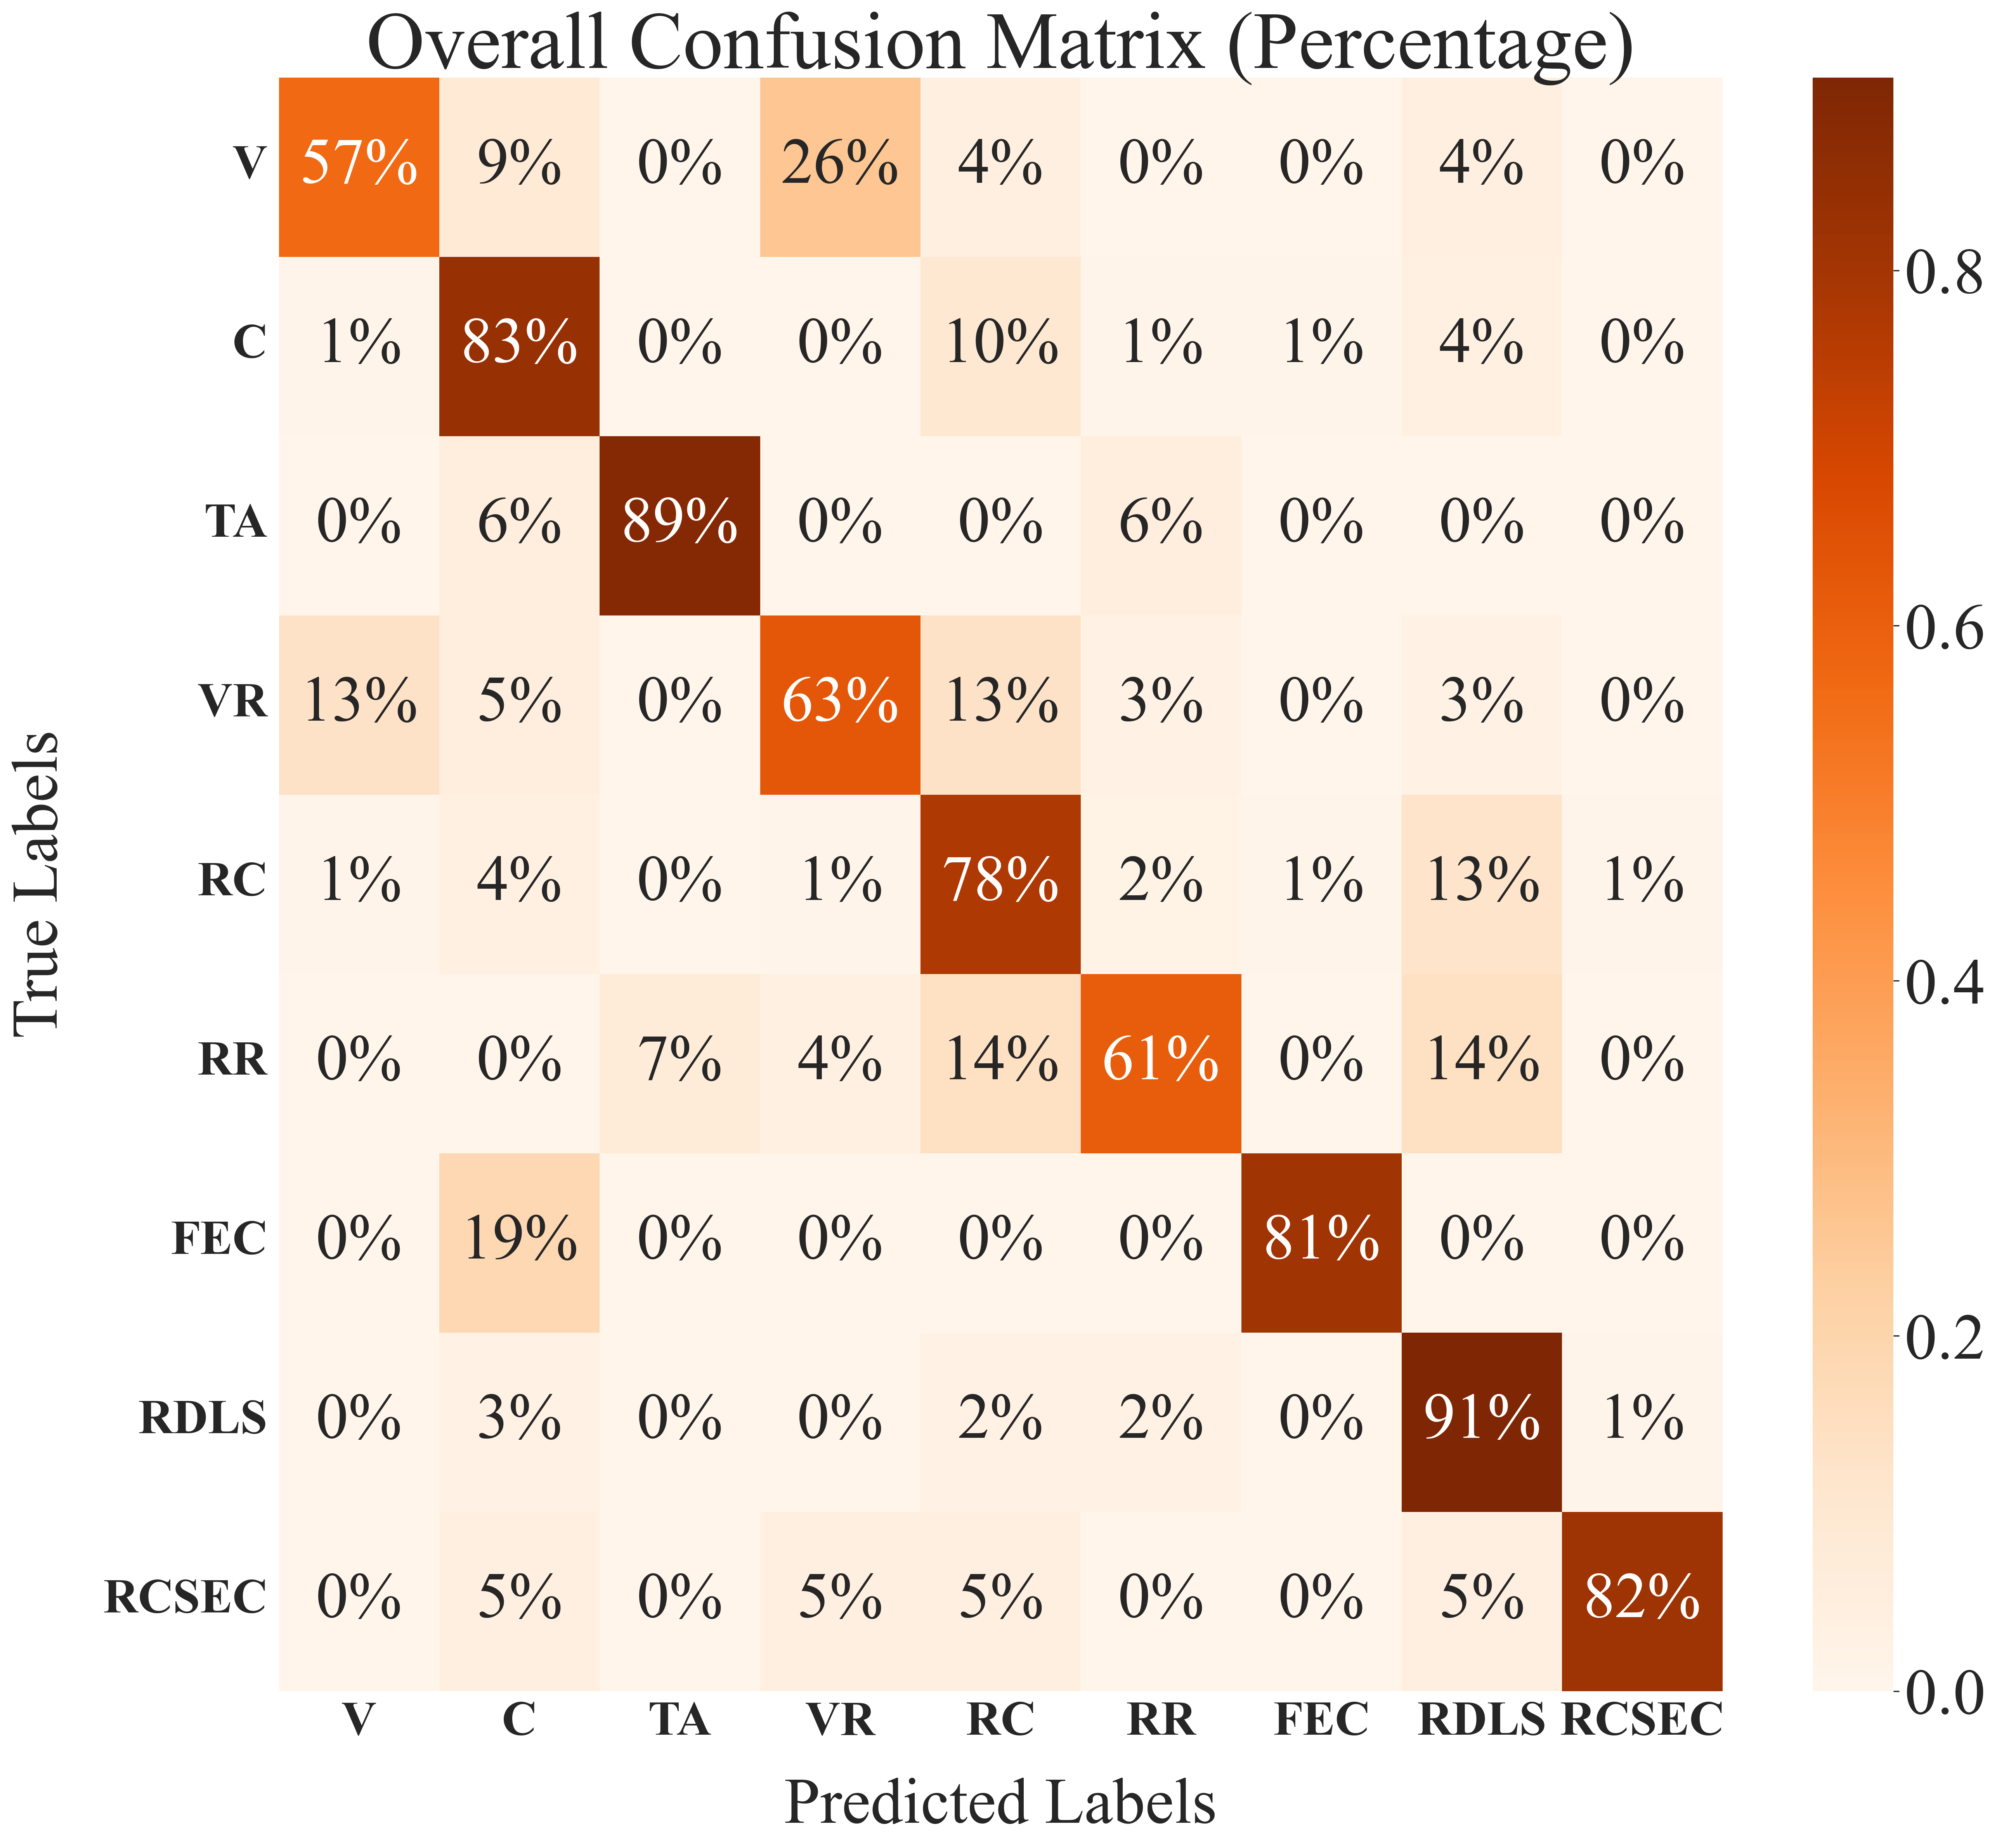

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = 'SimSun'
plt.rcParams['font.family']='Times New Roman ,SimSun '# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['figure.dpi'] = 300

classes = ['VR','RDLS','RC','V','RR','RCSEC','C','TA','FEC']
# V,C,TA,VR,RC,RR,FEC,RDLS,RCSEC
# 定义新的顺序
desired_order = ['V', 'C', 'TA', 'VR', 'RC', 'RR', 'FEC', 'RDLS', 'RCSEC']
row_indices = [classes.index(cls) for cls in desired_order]
cm_overall_reordered = cm_overall[row_indices][:, row_indices]

# 绘制热力图
plt.figure(figsize=(20, 18))
heatmap = sns.heatmap(cm_overall_reordered / cm_overall_reordered.sum(axis=1)[:, np.newaxis], annot=True, fmt='.0%', cmap='Oranges', xticklabels=desired_order, yticklabels=desired_order, annot_kws={'size': 40})
# plt.title('Overall Confusion Matrix (Percentage)', fontsize=40)
plt.xlabel('Predicted Labels', fontsize=40, labelpad=20)
plt.ylabel('True Labels', fontsize=40, labelpad=20)
plt.title('Overall Confusion Matrix (Percentage)', fontsize=50)
# 设置横轴和纵轴标签字体大小
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=30,weight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=30, weight='bold',  rotation=0)

# 获取图例对象
colorbar = heatmap.collections[0].colorbar

# 设置图例标签的大小
colorbar.ax.tick_params(labelsize=40)
plt.show()